In [305]:
import nltk, re, requests, oauth2, json
import pandas as pd
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt

from collections import Counter
from twython import Twython
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/brianwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Pull data from Twitter API

After playing around with the oauth2 library to try to access the Twitter API, I wasn't having as much luck as I'd like (it worked, but some parameters, such as number of tweets to return (count) weren't working.) In the end, I used the Twython library to access the Twitter API. I found it through a post on StackOverflow and it's a neat wrapper that is pretty easily to understand and use.

In [94]:
CONSUMER_KEY = 'MHK7n3fcuqePFfQ3bkwncspOp'
CONSUMER_SECRET = 'rTuDTaRBRveLxof2H6NzcFm5NbXKVVLwRRmLfirRKW1rSZwqbA'

In [ ]:
# I used this block of code to access the Twitter API before I discovered
# the Twython library. Keeping it here because it demonstrates how to use
# the oauth2 library.

def oauth_req(url, key, secret, http_method="GET", post_body="", http_headers=None):
    consumer = oauth2.Consumer(key=CONSUMER_KEY, secret=CONSUMER_SECRET)
    token = oauth2.Token(key=key, secret=secret)
    client = oauth2.Client(consumer, token)
    resp, content = client.request( url, method=http_method, body=bytes(post_body, 'utf-8'), headers=http_headers )
    return content

search = oauth_req(query1, 
                   '890560958-cXTMVY6QZc2Kz2R1n2iUPcoaVnRKeEpOrd1axwcV', 
                   'ddFSpKVJiDB7r2O47vVzEk1kHxFSzwyVhTIkVQpHMrNDn' )

In [95]:
topics = ["dogs", "cats", "pizza", "beyonce", "dinosaurs", "avengers", "summer", "hungry", "kanye", "ariana%20grande"]

In [176]:
from twython import Twython
twitter = Twython(app_key=CONSUMER_KEY,app_secret=CONSUMER_SECRET)
results = [ twitter.search(q=topic, count=100, result_type="popular", lang="en") for topic in topics ]

In [172]:
[ len(r["statuses"]) for r in results ]

[10, 15, 15, 15, 15, 12, 13, 15, 15, 15]

The API didn't return the same number of tweets for each query, but that's okay. I have some data to play with now. Now let's clean up the data where needed and make some visualizations!

The first two visualizations I'm going to make can be pretty simple. For the first visualization, I'm going to plot the distribution of favorites for each query and for the second visualization, I'm going to plot the distribution of retweets for each query.

In [227]:
favorite_counts = [ [ t["favorite_count"] for t in r["statuses"]] for r in results ]
retweet_counts = [ [ t["retweet_count"] for t in r["statuses"]] for r in results ]
avg_favorite_count = [ sum(x) / len(x) for x in favorite_counts ]
avg_retweet_count = [ sum(x) / len(x) for x in retweet_counts ]

In [269]:
queries = ["dogs", "cats", "pizza", "beyonce", "dinosaurs", "avengers", "summer", "hungry", "kanye", "ariana grande"]
colors = ['purple', 'pink', 'brown', 'yellow', 'b', 'r', 'orange', 'black', 'green', 'teal']

In [270]:
sorted_fav_counts = sorted(zip(avg_favorite_count, queries, colors), key=lambda x: -x[0])
sorted_rt_counts = sorted(zip(avg_retweet_count, queries, colors), key=lambda x: -x[0])

In [271]:
fav_heights = [ x[0] for x in sorted_fav_counts ]
fav_labels = [ x[1] for x in sorted_fav_counts ]
fav_colors = [ x[2] for x in sorted_fav_counts ]
rt_heights = [ x[0] for x in sorted_rt_counts ]
rt_labels = [ x[1] for x in sorted_rt_counts ]
rt_colors = [ x[2] for x in sorted_rt_counts ]

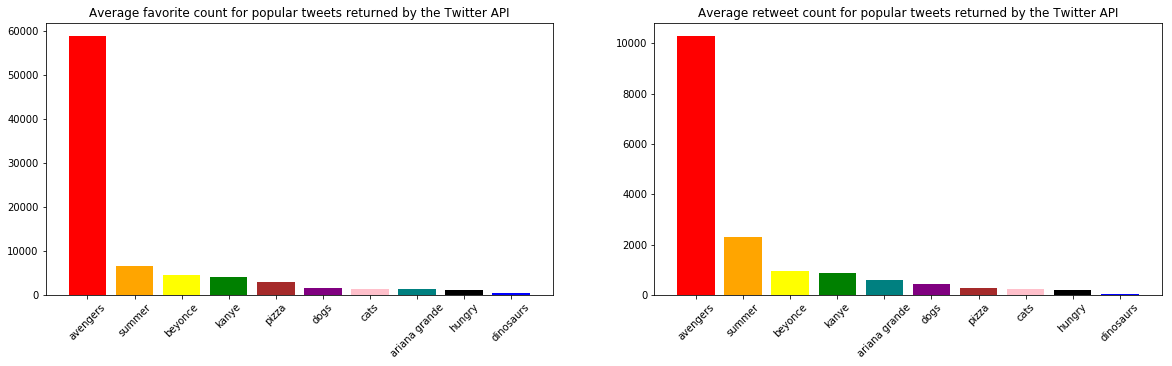

In [272]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
bars = ax[0].bar(x=fav_labels, height=fav_heights, color=fav_colors)
ax[0].tick_params(rotation=45, axis='x')
_ = ax[0].set_title("Average favorite count for popular tweets returned by the Twitter API")

bars = ax[1].bar(x=rt_labels, height=rt_heights, color=rt_colors)

ax[1].tick_params(rotation=45, axis='x')
_ = ax[1].set_title("Average retweet count for popular tweets returned by the Twitter API")

In [328]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [329]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # manually handling of retweets and urls
    tokens = [ w for w in tokens if w not in ["rt", "http", "co"] ]

    return tokens

In [356]:
def get_most_common_words(q):
    results = twitter.search(q=q, count=100, result_type="mixed", lang="en")
    text = [ r["text"] for r in results["statuses"] ]

    all_text = []
    for t in text:
        all_text += tokenize(t)
    
    return Counter(all_text).most_common(10)

In [358]:
get_most_common_words("avengers")

[('avenger', 95),
 ('endgame', 45),
 ('thanos', 18),
 ('spoiler', 17),
 ('making', 14),
 ('breakfast', 14),
 ('30secfights', 13),
 ('h54rwbj5zv', 13),
 ('without', 11),
 ('movie', 11)]

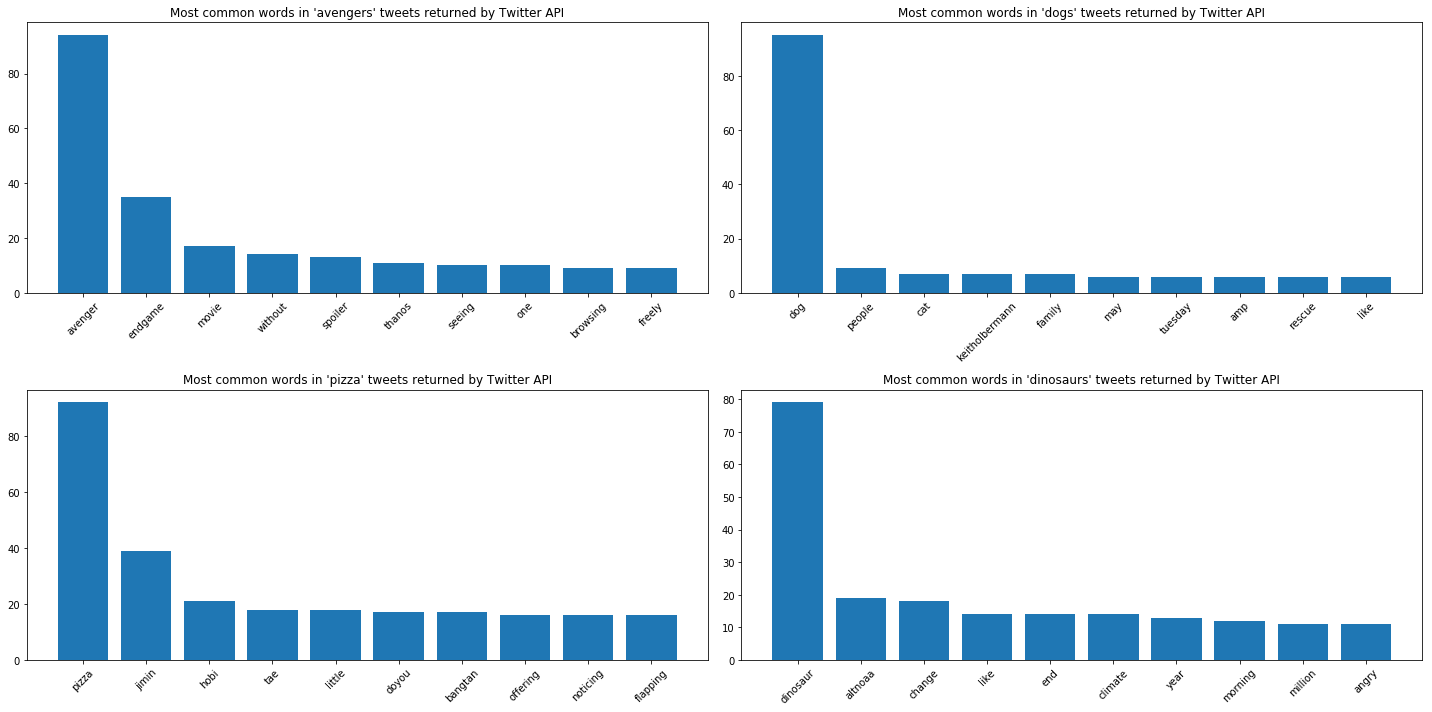

In [372]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

av_res = get_most_common_words("avengers")
height = [ x[1] for x in av_res ]
labels = [ x[0] for x in av_res ]
ax[0][0].bar(x=labels, height=height)
ax[0][0].tick_params(rotation=45, axis='x')
_ = ax[0, 0].set_title("Most common words in 'avengers' tweets returned by Twitter API")

dog_res = get_most_common_words("dogs")
height = [ x[1] for x in dog_res ]
labels = [ x[0] for x in dog_res ]
ax[0][1].bar(x=labels, height=height)
ax[0][1].tick_params(rotation=45, axis='x')
_ = ax[0, 1].set_title("Most common words in 'dogs' tweets returned by Twitter API")

pizza_res = get_most_common_words("pizza")
height = [ x[1] for x in pizza_res ]
labels = [ x[0] for x in pizza_res ]
ax[1][0].bar(x=labels, height=height)
ax[1][0].tick_params(rotation=45, axis='x')
_ = ax[1, 0].set_title("Most common words in 'pizza' tweets returned by Twitter API")

dino_res = get_most_common_words("dinosaurs")
height = [ x[1] for x in dino_res ]
labels = [ x[0] for x in dino_res ]
ax[1][1].bar(x=labels, height=height)
ax[1][1].tick_params(rotation=45, axis='x')
_ = ax[1, 1].set_title("Most common words in 'dinosaurs' tweets returned by Twitter API")
fig.tight_layout()